In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import load_model

Using TensorFlow backend.


In [0]:
#from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization,Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [0]:
import os
import numpy as np
import pandas as pd

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#Load train2014 file from GoogleDrive
id_train = '1bW7SW85Oa-eLkQNHSQrFIyq3-w993Cjx'
downloaded = drive.CreateFile({'id':id_train}) 
downloaded.GetContentFile('train.tar.gz')
! tar -xvzf train.tar.gz

In [0]:
#Load val2014 file from GoogleDrive
id_test = '119_LJgHme-w_rNjEaTWNIAbTDAZ6y1Iv'
#https://drive.google.com/open?id=119_LJgHme-w_rNjEaTWNIAbTDAZ6y1Iv
downloaded = drive.CreateFile({'id':id_test}) 
downloaded.GetContentFile('test.tar.gz')
! tar -xvzf test.tar.gz

In [0]:
#Load train.txt file from GoogleDrive
id_label = '1epQv3h8HZH_7nvXqiWKXwyea1T_2bR1m'
downloaded = drive.CreateFile({'id':id_label}) 
downloaded.GetContentFile('train.txt')

In [0]:
#load txt file.
label_txt = np.loadtxt('train.txt', dtype=bytes)
txt_name = label_txt[:,0].astype(str)
txt_labels = label_txt[:,1].astype(str)

In [0]:
#build a dataframe of the training label
label_file = np.append(txt_name.reshape(-1,1), txt_labels.reshape(-1,1), axis = 1)
df = pd.DataFrame(label_file, columns = ['Filenames', 'labels'])
df["labels"] = df["labels"].apply(lambda x:list(map(int, x.split(","))) )


In [0]:
#build a dataframe for predicting
df_test=pd.DataFrame(np.arange(0,15516).reshape((15516,1)),columns=['Filenames'])


In [0]:
for i in range(0,15516):
  df_test['Filenames'][i]=str(i)+'.jpg'

In [0]:
#df_test

In [24]:
#df

Filenames        labels
0          0.jpg      [13, 18]
1          1.jpg          [19]
2          2.jpg          [10]
3          3.jpg           [2]
4          4.jpg        [8, 7]
5          5.jpg          [19]
6          6.jpg           [0]
7          7.jpg          [19]
8          8.jpg      [18, 19]
9          9.jpg           [8]
10        10.jpg          [18]
11        11.jpg           [5]
12        12.jpg           [3]
13        13.jpg           [9]
14        14.jpg          [14]
15        15.jpg          [17]
16        16.jpg          [11]
17        17.jpg      [14, 19]
18        18.jpg           [9]
19        19.jpg          [17]
20        20.jpg           [3]
21        21.jpg          [19]
22        22.jpg          [11]
23        23.jpg       [16, 8]
24        24.jpg           [9]
25        25.jpg        [6, 9]
26        26.jpg           [4]
27        27.jpg           [6]
28        28.jpg           [8]
29        29.jpg           [8]
...          ...           ...
31895  31895.jpg          [19]
31896  31896.jpg          [14]
31897  31897.jpg           [9]
31898  31898.jpg           [2]
31899  31899.jpg           [4]
31900  31900.jpg       [7, 16]
31901  31901.jpg           [4]
31902  31902.jpg          [11]
31903  31903.jpg          [14]
31904  31904.jpg          [11]
31905  31905.jpg        [8, 7]
31906  31906.jpg           [6]
31907  31907.jpg          [18]
31908  31908.jpg           [8]
31909  31909.jpg           [6]
31910  31910.jpg          [14]
31911  31911.jpg      [16, 13]
31912  31912.jpg           [6]
31913  31913.jpg          [19]
31914  31914.jpg          [11]
31915  31915.jpg          [19]
31916  31916.jpg          [13]
31917  31917.jpg           [6]
31918  31918.jpg           [3]
31919  31919.jpg      [19, 16]
31920  31920.jpg           [0]
31921  31921.jpg  [18, 19, 11]
31922  31922.jpg          [19]
31923  31923.jpg      [18, 19]
31924  31924.jpg          [16]

[31925 rows x 2 columns]

In [32]:
#split dataset into training set and validation set
import math
cv_proportion = 0.8 #set cv proportion as 0.8
train_num = math.floor(len(df)*cv_proportion)
train_df = df[ :train_num]
vali_df = df[train_num:]
print('sum of training:'+str(len(train_df)))
print('sum of validation:'+str(len(vali_df)))
print("total: "+str(len(train_df) + len(vali_df)))

sum of training:25540
sum of validation:6385
total: 31925


In [117]:
#build image data generator for training and validation
#normalize and resize the image
datagen=keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)
test_datagen=keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)
train_generator=datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = "./train2014/",
    x_col = 'Filenames',
    y_col = 'labels',
    has_ext = True,
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (224,224)
    )

valid_generator=test_datagen.flow_from_dataframe(
    dataframe = vali_df,
    directory = "./train2014/",
    x_col = "Filenames",
    has_ext = True,
    y_col = None,
    batch_size = 32,
    seed = 42,
    shuffle = False,
    class_mode = None,
    target_size = (224,224)
    )


Found 25540 images belonging to 20 classes.
Found 6385 images.


In [0]:
a,b=train_generator.next()

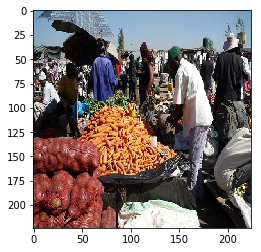

In [40]:
import matplotlib.pyplot as plt
plt.imshow(a[0])
plt.show() #show a resized image

In [41]:
b[0] #show the corresponded one-hot label of the image


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0.], dtype=float32)

In [44]:
#Load resnet50 from Keras as the base model
model = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet',input_shape=(224,224,3))
model.trainable = False

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [0]:
#build up a new model on the basic of resnet50
model_1 = tf.keras.Sequential([
  model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(20, activation='sigmoid')
])

In [0]:
#Compile the model with lr=0.0001 and use binary_crossentropy.
model_1.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

In [48]:
len(model_1.trainable_variables)

2

In [50]:
#start the 1st training
epochs = 20
batch_size = 32

steps_per_epoch = train_generator.n // batch_size

history = model_1.fit_generator(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs = epochs,
                              workers = 4)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
799/799 [==============================] - 119s 149ms/step - loss: 0.1879 - acc: 0.9364
Epoch 2/20
799/799 [==============================] - 115s 144ms/step - loss: 0.1452 - acc: 0.9474
Epoch 3/20
799/799 [==============================] - 115s 144ms/step - loss: 0.1360 - acc: 0.9504
Epoch 4/20
799/799 [==============================] - 115s 143ms/step - loss: 0.1309 - acc: 0.9522
Epoch 5/20
799/799 [==============================] - 114s 143ms/step - loss: 0.1276 - acc: 0.9532
Epoch 6/20
799/799 [==============================] - 114s 143ms/step - loss: 0.1249 - acc: 0.9540
Epoch 7/20
799/799 [==============================] - 114s 143ms/step - loss: 0.1229 - acc: 0.9547
Epoch 8/20
799/799 [==============================] - 114s 143ms/step - loss: 0.1211 - acc: 0.9553
Epoch 9/20
799/799 [==============================] - 114s 143ms/step - loss: 0.1196 - acc: 0.9558
Epoch 10/20
799/799 [==============================] - 114s 1

In [55]:
#predict the labels of the validation set
valid_generator.reset()
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
pred = model_1.predict_generator(valid_generator,
                               steps = STEP_SIZE_VALID,
                               verbose = 1)

200/200 [==============================] - 27s 133ms/step


In [58]:
pred_label = np.argmax(pred, axis=1)#find the index of the biggest probability
true_label = vali_df["labels"].values
count = 0
for i in range(pred_label.shape[0]):
    if pred_label[i] in true_label[i]:
        count += 1

print(count/pred_label.shape[0])# calculate the accuracy

0.6711041503523885


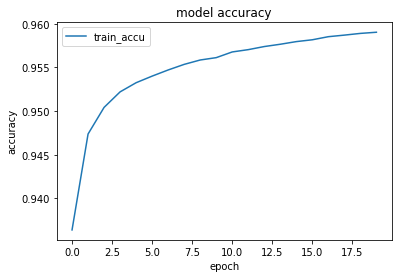

In [62]:
#Draw accuracy plot.
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accu', 'test_accu'], loc='upper left')
plt.show()

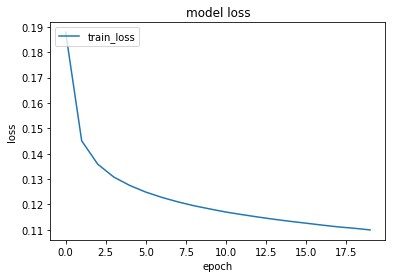

In [63]:
#Draw loss plot.
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'test_loss'], loc='upper left')
plt.show()

In [70]:
model.trainable = True
print(len(model.layers))#show the number of the layers in the model

175


In [0]:
# Freeze the layers before the 150th layer.
for layer in model.layers[:150]:
    layer.trainable =  False

In [0]:
model_1.compile(optimizer = tf.keras.optimizers.RMSprop(lr=2e-5),
                loss= 'binary_crossentropy',
                metrics=['accuracy'])

In [74]:
model_1.summary()#show the model's structure

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                40980     
Total params: 23,628,692
Trainable params: 11,079,700
Non-trainable params: 12,548,992
_________________________________________________________________


In [0]:
callbacks = [EarlyStopping(monitor='loss', patience=3),
             ModelCheckpoint(filepath='best_model.h5', monitor='loss', save_best_only=True)]

In [79]:
#start the 2nd training
epochs = 15
batch_size = 32
history = model_1.fit_generator(train_generator,
                                steps_per_epoch = steps_per_epoch,
                                #callbacks=callbacks,
                                epochs = epochs,
                                workers = 4)

Epoch 1/30
799/799 [==============================] - 135s 169ms/step - loss: 0.1073 - acc: 0.9600
Epoch 2/30
799/799 [==============================] - 133s 166ms/step - loss: 0.0856 - acc: 0.9684
Epoch 3/30
799/799 [==============================] - 132s 166ms/step - loss: 0.0673 - acc: 0.9762
Epoch 4/30
799/799 [==============================] - 132s 166ms/step - loss: 0.0496 - acc: 0.9838
Epoch 5/30
799/799 [==============================] - 132s 165ms/step - loss: 0.0328 - acc: 0.9910
Epoch 6/30
799/799 [==============================] - 133s 166ms/step - loss: 0.0183 - acc: 0.9963
Epoch 7/30
799/799 [==============================] - 133s 166ms/step - loss: 0.0083 - acc: 0.9989
Epoch 8/30
799/799 [==============================] - 133s 167ms/step - loss: 0.0033 - acc: 0.9997
Epoch 9/30
799/799 [==============================] - 133s 167ms/step - loss: 0.0016 - acc: 0.9998
Epoch 10/30
799/799 [==============================] - 133s 167ms/step - loss: 8.6524e-04 - acc: 0.9999
Epoch

KeyboardInterrupt: ignored

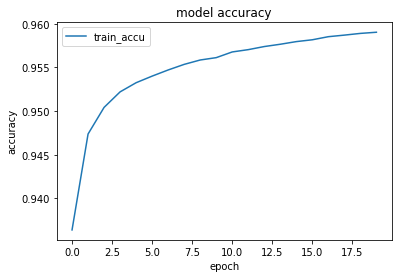

In [81]:
#Draw accuracy plot.
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accu', 'test_accu'], loc='upper left')
plt.show()

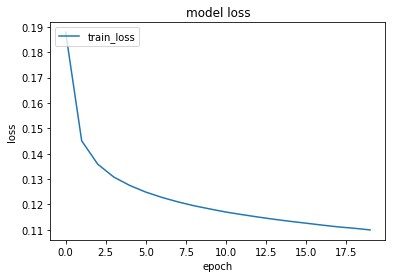

In [82]:
#Draw loss plot.
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'test_loss'], loc='upper left')
plt.show()

In [80]:
valid_generator.reset()
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
pred_1 = model_1.predict_generator(valid_generator,
                                   steps = STEP_SIZE_VALID,
                                   verbose = 1)
pred_label_1 = np.argmax(pred_1, axis=1)
true_label_1 = vali_df["labels"].values

count = 0
for i in range(pred_label_1.shape[0]):
    if pred_label_1[i] in true_label_1[i]:
        count += 1

print(count/pred_label_1.shape[0])

200/200 [==============================] - 26s 130ms/step
0.6776820673453406


In [83]:
pred_label_1 #show the predicted label of the validation set

array([ 2,  2,  2, ..., 16, 18, 16])

In [0]:
import datetime
  # create the model file with the format of '.h5'
time = datetime.datetime.now().strftime('%m-%d %H:%M')
print(time)
model_1.save('/content'+'/ResNet50_bestmodel_{epochs}epochs_{time}.h5'.format(epochs=epochs,time=time))
print("model is saved.")

In [119]:
#build the test_generator for the predicted dataset
test_generator=test_datagen.flow_from_dataframe(
    dataframe = df_test,
    directory = "./val2014/",
    x_col = "Filenames",
    has_ext = True,
    y_col = None,
    batch_size = 32,
    seed = 42,
    shuffle = False,
    class_mode = None,
    target_size = (224,224)
    )

Found 15516 images.


In [106]:
#predict the dataset
test_generator.reset()
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size
pred_1_test = model_1.predict_generator(test_generator,
                                        steps = STEP_SIZE_TEST,
                                        verbose = 1)
pred_label_test = np.argmax(pred_1_test, axis=1)
#true_label_1 = vali_df["labels"].values


485/485 [==============================] - 69s 143ms/step


In [111]:
len(pred_label_test)#generate 15516 predicted labels

15516

In [0]:
#write the predicted results in txt file named as 'Predicted_labels.txt'
import sys
file = open('Predict_labels.txt','w')
 

for i in range(0,15516):
  file.write(df_test['Filenames'][i]+"\t\t")
  file.write(str(pred_label_test[i])+'\n')
  
file.close()

In [89]:
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                40980     
Total params: 23,628,692
Trainable params: 11,079,700
Non-trainable params: 12,548,992
_________________________________________________________________
